In [269]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import display, clear_output


# Cleaning the Data

## Reddit

In [233]:
reddit = pd.read_csv('reddit_sample_end.csv')
reddit = reddit[['created_utc','body']]
#reddit.set_index('created_utc', inplace = True)
reddit.head()
reddit = reddit.dropna()

In [234]:
# Drop "[deleted]" and "[removed]" text bodies
deleted = list()

for i in range(len(reddit)):
    if reddit.body.iloc[i] == '[deleted]' or reddit.body.iloc[i] == '[removed]':
        deleted.append(reddit.index[i])
reddit = reddit.drop(deleted)

In [235]:
# Clean non-integer utc
non_int = list()
for i in range(len(reddit)):
    if type(reddit.created_utc.iloc[i]) == str: # We need to clean all UTC values in strings
        if len(reddit.created_utc.iloc[i])<10: # All UTCs have at least 10 digits
            non_int.append(reddit.index[i])
reddit = reddit.drop(non_int)

reddit['created_utc'] = reddit.created_utc.astype(int)

# Convert utc to datetime
test = reddit.head()

    # Make list of date from utc to datetime
dates = list() 
for utc in reddit.created_utc:
    dates.append(dt.datetime.fromtimestamp(utc))
    
    # Add dates list to dataframe
reddit['dates'] = dates 
    # Delete utc column
reddit.drop(['created_utc'],axis=1,inplace=True)

reddit.tail()

,body,dates
99994,.. is that.. why yes it is! k-lite codec pack!...,2010-01-31 18:59:53
99995,Why not include the flight costs too?,2010-01-31 18:59:54
99996,"How, is that humanly, possible.\n\n,",2010-01-31 18:59:55
99997,I wouldn't be surprised if the XBLA/PSN/Wii Vi...,2010-01-31 18:59:56
99998,Pidgeon.,2010-01-31 18:59:56


### Text Cleaning

In [236]:
def clean_text(df,text_col):
    
    '''Cleans text column from dataframe'''

    # Make all upper case
    df[text_col] = df[text_col].str.upper()

    # Remove symbols
    symbols = '`-=~!@#$%^&*()_+[]\{}|;:,./<>?"1234567890'

    for s in symbols:
        df[text_col] = df[text_col].str.replace(s,'')
        
        
    return df

In [237]:
reddit = clean_text(reddit,'body')

In [238]:
reddit['body'] = reddit.body.str.split()
display(reddit.head())

feed_reddit = reddit

,body,dates
0,"[PANI, PONI, DASH]",2010-01-30 14:18:35
1,"[I, GOT, CALLED, IN, LAST, TIME, IT, SNOWED, T...",2010-01-30 14:18:37
2,"[FOR, REAL, I, DON'T, GO, TO, CHURCH, AND, I'M...",2010-01-30 14:18:37
3,"[CAN'T, GO, WRONG, WITH, AM, I, WRONG]",2010-01-30 14:18:38
4,[PROBABLY],2010-01-30 14:18:38


### New York Times

In [239]:
nyt = pd.read_csv('nyt.csv')
nyt.columns

Index(['Unnamed: 0', '_id', 'abstract', 'blog', 'byline', 'document_type',
       'headline', 'keywords', 'multimedia', 'new_desk', 'print_page',
       'pub_date', 'score', 'section_name', 'slideshow_credits', 'snippet',
       'source', 'type_of_material', 'uri', 'web_url', 'word_count'],
      dtype='object')

In [240]:
nyt = nyt[['pub_date','snippet']]
nyt = nyt.dropna()
nyt = nyt.drop_duplicates()

In [241]:
nyt = clean_text(nyt,'snippet')
nyt.head()

,pub_date,snippet
0,2006-01-01T00:00:00Z,WHILE JET SETTERS SCHUSS DOWN THE GROOMED SLOP...
1,2006-01-01T00:00:00Z,THANKS FOR JESSE GREEN'S TERRIFIC ARTICLE DEC ...
2,2006-01-01T00:00:00Z,THE WORD FAMIGLIA IN A FOOD STORE'S NAME CAN B...
3,2006-01-01T00:00:00Z,AS PEOPLE WAKE UP FROM ANOTHER NEW YEAR'S EVE ...
4,2006-01-01T00:00:00Z,WILD BIRDS HAVE COMPLETED THEIR SEASONAL MIGRA...


In [242]:
nyt['snippet'] = nyt['snippet'].str.split()
display(nyt.head())

feed_nyt = nyt

,pub_date,snippet
0,2006-01-01T00:00:00Z,"[WHILE, JET, SETTERS, SCHUSS, DOWN, THE, GROOM..."
1,2006-01-01T00:00:00Z,"[THANKS, FOR, JESSE, GREEN'S, TERRIFIC, ARTICL..."
2,2006-01-01T00:00:00Z,"[THE, WORD, FAMIGLIA, IN, A, FOOD, STORE'S, NA..."
3,2006-01-01T00:00:00Z,"[AS, PEOPLE, WAKE, UP, FROM, ANOTHER, NEW, YEA..."
4,2006-01-01T00:00:00Z,"[WILD, BIRDS, HAVE, COMPLETED, THEIR, SEASONAL..."


### Twitter

In [243]:
twitter = pd.read_csv('twitter.csv')

In [244]:
twitter = twitter[['Date','Tweet_content']]

In [245]:
twitter = clean_text(twitter,'Tweet_content')

In [246]:
twitter['Tweet_content'] = twitter['Tweet_content'].str.split()
display(twitter.head())

feed_twitter = twitter

,Date,Tweet_content
0,2016-04-16,"[WIND, MPH, NNE, BAROMETER, IN, RISING, SLOWLY..."
1,2016-04-16,"[PAUSA, PRO, CAFÉ, ANTES, DE, EMBARCAR, NO, PR..."
2,2016-04-16,"[GOOD, MORNING, MORNING, SATURDAY, DINER, VT, ..."
3,2016-04-16,"[GRATEFULDEAD, RECORDSTOREDAYUS, 🌹🌹🌹, TOMS, MU..."
4,2016-04-16,"[EGG, IN, A, MUFFIN, ROCKET, BABY, BAKERY, ROC..."


# Word Frequency Distribution

In [247]:
def word_freq(name, feed_df):
    
    '''returns database with words and word frequency given the dataframe with list of words'''
    
    ## Creating the word frequency distribution
    
        # Create list of all words in the dataframe
    words = list()
    for i in range(len(feed_df)):
        words.extend(feed_df.iloc[i])
        
        # Create list of unique words    
    word_set = list(set(words))

        # Create list of unique words and their frequency
    word_freq = list()
    for i in word_set:
        word_freq.append([i,words.count(i)])
    
    
    # Creating 
    word = name+'_word'
    freq = name+'_freq'
    labels = [word,freq]
    
    df = pd.DataFrame.from_records(word_freq, columns=labels)
    df = df.sort_values([freq,word],ascending = [0,1])
    df = df.reset_index().drop('index',axis=1)
    
    return df

In [248]:
def word_perc(name, df, numwords):

    '''Outputs word frequency percentages'''

    y_var = name+'_perc'
    
    # Determine length of the 
    if type(numwords) == str:
        if numwords.lower() == 'all':
            df = df
    elif type(numwords) == int or type(numwords) == float:
        df = df.head(int(numwords))
    else:
        print('List length error')

    freq = name+'_freq'
    #df[xvar] = (df.index+1)
    df[y_var] = (df[freq])/(df[freq].agg('sum'))*100

    df
    
    return df

In [249]:
def perc_cum(df):

    """Returns cumulative frequency percentage. Requires word_perc() first."""
    
    for col in df.columns:
        if 'perc' in col:
            name = col

    cum_list = list()
    perc = 0

    for i in range(len(df)):
        perc += df[name].iloc[i]
        cum_list.append(perc)
    df[name+'_cum'] = cum_list

    return df

## Creating Frequency Dataframes

In [251]:
# We use .head() to limit the sample size... otherwise proceesing the data would take too long
reddit_all = word_freq('reddit',feed_reddit.body.head(5000))
nyt_all = word_freq('nyt',feed_nyt.snippet)
twitter_all = word_freq('twitter',feed_twitter.Tweet_content.head(10000))

In [297]:
# Number of words we want to rank
num_ranked_words = 100 # an integer or 'all'

### Reddit

In [298]:
reddit = word_perc('reddit',reddit_all,num_ranked_words)
reddit = perc_cum(reddit)

clear_output() # Clear warning flag output from functions

display(reddit.head())
display(reddit.tail())

,reddit_word,reddit_freq,reddit_perc,reddit_perc_cum
0,THE,7845,8.452298,8.452298
1,TO,4980,5.365512,13.817810
2,A,4605,4.961483,18.779292
3,AND,4067,4.381835,23.161127
4,I,4037,4.349512,27.510639


,reddit_word,reddit_freq,reddit_perc,reddit_perc_cum
95,YOU'RE,249,0.268276,98.951678
96,TOO,248,0.267198,99.218876
97,THOSE,245,0.263966,99.482842
98,SOMETHING,240,0.258579,99.741421
99,WHY,240,0.258579,100.000000


### New York Times

In [299]:
# Create DataFrame
nyt = word_perc('nyt',nyt_all,num_ranked_words)
nyt = perc_cum(nyt)

clear_output() # Clear warning flag output from functions

display(nyt.head())
display(nyt.tail())

,nyt_word,nyt_freq,nyt_perc,nyt_perc_cum
0,THE,1774,13.994951,13.994951
1,OF,1039,8.196592,22.191543
2,A,945,7.455033,29.646576
3,AND,880,6.942253,36.588829
4,TO,642,5.064689,41.653518


,nyt_word,nyt_freq,nyt_perc,nyt_perc_cum
95,TIMES,28,0.220890,99.147996
96,CHICKEN,27,0.213001,99.360997
97,LOVE,27,0.213001,99.573998
98,MOTHER,27,0.213001,99.786999
99,TIME,27,0.213001,100.000000


### Twitter

In [300]:
twitter = word_perc('twitter',twitter_all,num_ranked_words)
twitter = perc_cum(twitter)

clear_output() # Clear warning flag output from functions

display(twitter.head())
display(twitter.tail())

,twitter_word,twitter_freq,twitter_perc,twitter_perc_cum
0,IN,2501,6.168759,6.168759
1,JOB,1871,4.614853,10.783612
2,THE,1721,4.244876,15.028488
3,TO,1681,4.146215,19.174703
4,AT,1664,4.104284,23.278988


,twitter_word,twitter_freq,twitter_perc,twitter_perc_cum
95,ONE,138,0.340379,98.673014
96,CITY,137,0.337913,99.010927
97,CARE,135,0.332980,99.343906
98,CALIFORNIA,133,0.328047,99.671953
99,JOIN,133,0.328047,100.000000


### Word Rank (Combining all platforms)

In [301]:
wordrank = pd.merge(reddit,nyt,how='outer',right_index=True,left_index=True)
wordrank = pd.merge(wordrank,twitter,how='outer',right_index=True,left_index=True)
wordrank['rank'] = (wordrank.index+1)

display(wordrank.head(10))
display(wordrank.tail(10))

,reddit_word,reddit_freq,reddit_perc,reddit_perc_cum,nyt_word,nyt_freq,nyt_perc,nyt_perc_cum,twitter_word,twitter_freq,twitter_perc,twitter_perc_cum,rank
0,THE,7845,8.452298,8.452298,THE,1774,13.994951,13.994951,IN,2501,6.168759,6.168759,1
1,TO,4980,5.365512,13.817810,OF,1039,8.196592,22.191543,JOB,1871,4.614853,10.783612,2
2,A,4605,4.961483,18.779292,A,945,7.455033,29.646576,THE,1721,4.244876,15.028488,3
3,AND,4067,4.381835,23.161127,AND,880,6.942253,36.588829,TO,1681,4.146215,19.174703,4
4,I,4037,4.349512,27.510639,TO,642,5.064689,41.653518,AT,1664,4.104284,23.278988,5
5,OF,3726,4.014437,31.525077,IN,611,4.820133,46.473651,A,1649,4.067287,27.346274,6
6,YOU,2799,3.015676,34.540753,BY,342,2.698012,49.171663,HIRING,1573,3.879831,31.226106,7
7,THAT,2717,2.927329,37.468082,ON,310,2.445566,51.617229,FOR,1087,2.681104,33.907210,8
8,IS,2667,2.873458,40.341540,FOR,308,2.429789,54.047018,THIS,975,2.404854,36.312064,9
9,IN,2663,2.869148,43.210688,IS,286,2.256232,56.303250,AND,913,2.251930,38.563994,10


,reddit_word,reddit_freq,reddit_perc,reddit_perc_cum,nyt_word,nyt_freq,nyt_perc,nyt_perc_cum,twitter_word,twitter_freq,twitter_perc,twitter_perc_cum,rank
90,SHOULD,258,0.277972,97.598449,FOOD,28,0.220890,98.043547,IF,146,0.360111,96.934119,91
91,GO,254,0.273663,97.872111,FORMER,28,0.220890,98.264437,RN,145,0.357645,97.291764,92
92,INTO,252,0.271508,98.143619,JUST,28,0.220890,98.485327,NOW,142,0.350245,97.642010,93
93,COULD,251,0.270430,98.414049,LIFE,28,0.220890,98.706216,ALL,141,0.347779,97.989789,94
94,BEEN,250,0.269353,98.683402,SHE,28,0.220890,98.927106,YOUR,139,0.342846,98.332634,95
95,YOU'RE,249,0.268276,98.951678,TIMES,28,0.220890,99.147996,ONE,138,0.340379,98.673014,96
96,TOO,248,0.267198,99.218876,CHICKEN,27,0.213001,99.360997,CITY,137,0.337913,99.010927,97
97,THOSE,245,0.263966,99.482842,LOVE,27,0.213001,99.573998,CARE,135,0.332980,99.343906,98
98,SOMETHING,240,0.258579,99.741421,MOTHER,27,0.213001,99.786999,CALIFORNIA,133,0.328047,99.671953,99
99,WHY,240,0.258579,100.000000,TIME,27,0.213001,100.000000,JOIN,133,0.328047,100.000000,100


# The 80/20 Rule

In [692]:
def plot_bar_20():
    
    fig, ax = plt.subplots(3, figsize = (10,10))

    top20 = round(.2*len(wordrank)) - 1 # position of 20th ranked word (-1 for indexing)

    plt.suptitle('Top 20% Rank Cumulative Frequency', size = 16, fontweight = 'bold')

    #plt.tight_layout(pad = 1, h_pad=1.5)

    source_list = ['reddit','nyt','twitter']

    for i in range(len(source_list)):
        ax[i].bar(wordrank['rank'], wordrank[source_list[i]+'_perc'],align='edge', width=1)
        ax[i].bar(wordrank['rank'].head(top20), wordrank[source_list[i]+'_perc'].head(top20),align='edge', width=1)

        ax[i].set_xlim(1,len(wordrank))
        ax[i].set_ylim(0,15)

        ax[i].set_title('\n'+source_list[i].title(),size = 14)

        cum_freq_str = str(round(wordrank[source_list[i]+'_perc_cum'].loc[top20],2))

        message1 = "Top 20% Used Words:\n"
        message2 =  cum_freq_str + '% Total Use'

        ax[i].axvline(x=top20+1, label= "20% Mark", linestyle='--', linewidth=2)
        ax[i].text(top20+3, 7.5, message1, horizontalalignment='left',size=12)
        ax[i].text(top20+3, 7.5, message2, horizontalalignment='left', fontweight='bold',size=12)


        cumfreq80 = wordrank.index[wordrank[source_list[i]+'_perc_cum'] > 80][0]
        ax[i].axvline(x=cumfreq80+1, label= "20% Mark", linestyle=':', linewidth=2, color ='r', alpha=.5)
        ax[i].text(cumfreq80, 4, '80% Cum.\nFreq. Line', horizontalalignment='center', alpha = .5)

        ax[i].spines["right"].set_visible(False)
        ax[i].spines["top"].set_visible(False)

    ax[1].set_title("New York Times",size = 14)

    ax[2].set_xlabel("Word Frequency Rank", size=16,fontweight='bold')
    ax[1].set_ylabel('Word Frequency % in population\n', size = 16,fontweight='bold')

    plt.show()

In [693]:
def plot_bar_80():

    fig, ax = plt.subplots(3, figsize = (10,10))

    top20 = round(.2*len(wordrank)) - 1 # position of 20th ranked word (-1 for indexing)

    plt.suptitle('80% Cumulative Frequency Word Rank', size = 16, fontweight = 'bold')

    #plt.tight_layout(pad = 1, h_pad=1.5)

    source_list = ['reddit','nyt','twitter']

    for i in range(len(source_list)):

        cumfreq80 = wordrank.index[wordrank[source_list[i]+'_perc_cum'] > 80][0]

        ax[i].bar(wordrank['rank'], wordrank[source_list[i]+'_perc'],align='edge', width=1)
        ax[i].bar(wordrank['rank'].head(cumfreq80), wordrank[source_list[i]+'_perc'].head(cumfreq80),align='edge', width=1)

        ax[i].set_xlim(1,len(wordrank))
        ax[i].set_ylim(0,15)

        ax[i].set_title('\n'+source_list[i].title(),size = 14)

        rank_str = str(cumfreq80/len(wordrank)*100)

        message1 = str(round(wordrank[source_list[i]+'_perc_cum'][cumfreq80],2)) + "% Total Use:"
        message2 = "Top " + rank_str +'% Used Words\nRank '+str(cumfreq80)

        ax[i].axvline(x=cumfreq80+1, label= "20% Mark", linestyle='--', linewidth=2, color ='r', alpha=1)
        ax[i].text(cumfreq80+3, 7.5, message1,
                   horizontalalignment='left',verticalalignment='bottom', size = 14)
        ax[i].text(cumfreq80+3, 7.5, message2,
                   horizontalalignment='left',verticalalignment='top', fontweight='bold', size = 14)


        ax[i].axvline(x=top20+1, label= "20% Mark", linestyle=':', linewidth=2,alpha = .5)
        ax[i].text(top20, 7.5, '20% Rank Line', horizontalalignment='center',alpha = .8)

        ax[i].spines["right"].set_visible(False)
        ax[i].spines["top"].set_visible(False)

    ax[1].set_title("New York Times",size = 14)

    ax[2].set_xlabel("Word Frequency Rank", size=16,fontweight='bold')
    ax[1].set_ylabel('Word Frequency % in population\n', size = 16,fontweight='bold')

    plt.show()

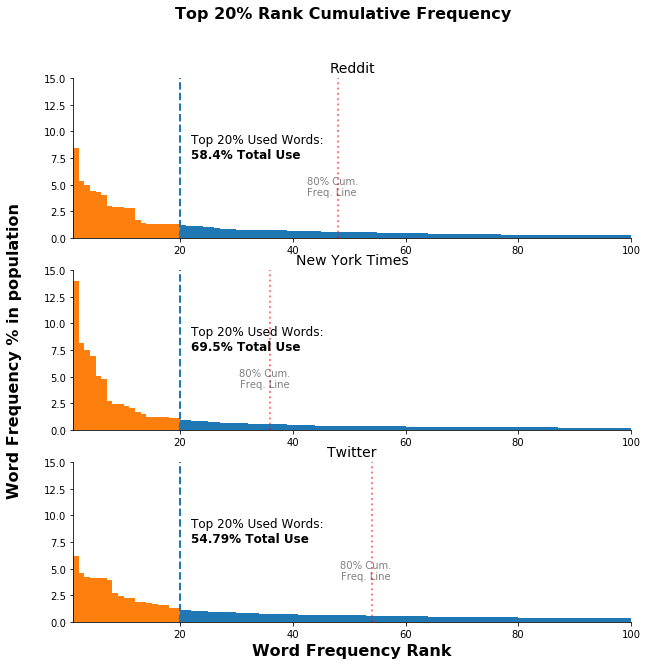

In [694]:
plot_bar_20()

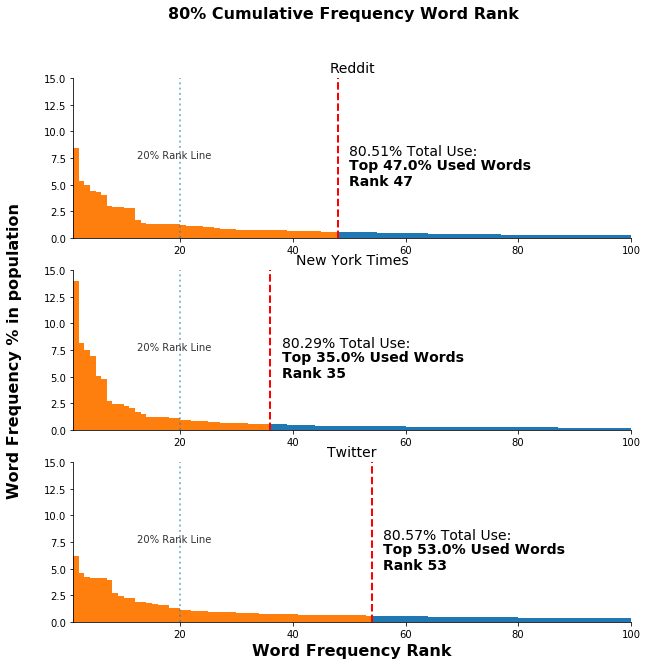

In [695]:
plot_bar_80()

In [684]:
def plot_zipf(source,name,show_summary):

    results = smf.ols("np.log({source}_perc) ~ np.log(rank)".format(source = source), 
                      data=wordrank).fit()


    source = "{source}_perc".format(source = source)


    fig, ax = plt.subplots(figsize = (10,6))

    ax.set_title(name+': Data v Prediction', size=18,fontweight='bold')

    # Plot Actual data
    data = ax.scatter(np.log(wordrank["rank"]), np.log(wordrank[source]),
               alpha = .5, s = wordrank[source]*300/wordrank["rank"],
               label = name+' Data')

    # Plot Prediction
    pred = results.predict(exog = wordrank["rank"])

    prediction = ax.scatter(np.log(wordrank["rank"]), pred,
               marker = (4, 0, 25), s = np.exp(pred)*300/wordrank["rank"],
               alpha = .5, #color = 'orange',
               label = 'Prediction')

    # Formatting
    ax.set_ylabel('Log Frequency %',size=14,fontweight='bold')
    ax.set_xlabel('Log Rank',size=14,fontweight='bold')

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    message1 = 'Log Rank Coeff: '+str(round(results.params['np.log(rank)'],4))
    message2 = 'Intercept: '+str(round(results.params['Intercept'],3))
    message3 = 'R-Squared: '+str(round(results.rsquared,3))

    statistics = '\n'.join([message1,message2,message3])

    ax.text(np.log(1),0,'Regression Statistics:',
            horizontalalignment='left',verticalalignment='bottom',
            size=12,fontweight='bold',fontstyle='italic')

    ax.text(np.log(1),0,statistics,
            horizontalalignment='left', verticalalignment='top',
            size=12)

    # Legend
    legend_prop = dict(size=10,weight='bold',style='italic')
    first_legend = plt.legend(handles=[data], bbox_to_anchor=(1, .9),prop=legend_prop)
    ax = plt.gca().add_artist(first_legend)
    plt.legend(handles=[prediction], bbox_to_anchor=(1, .8),prop=legend_prop)

    plt.show()

    # Show regression summary
    if show_summary == True:
        print(results.summary())

# Zipf!

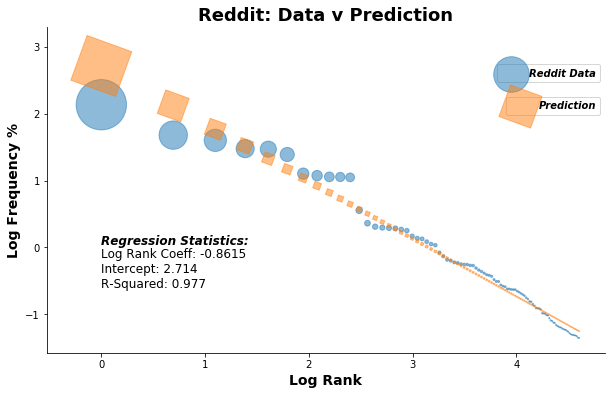

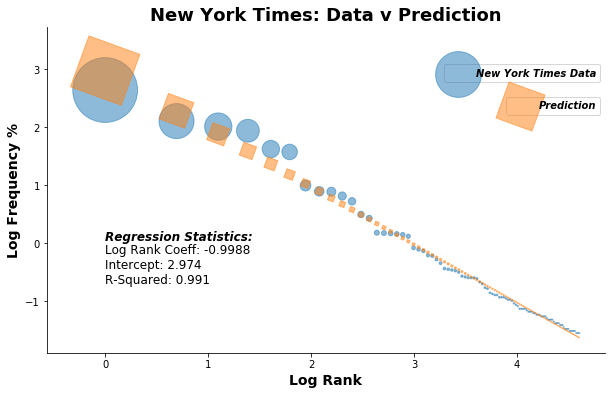

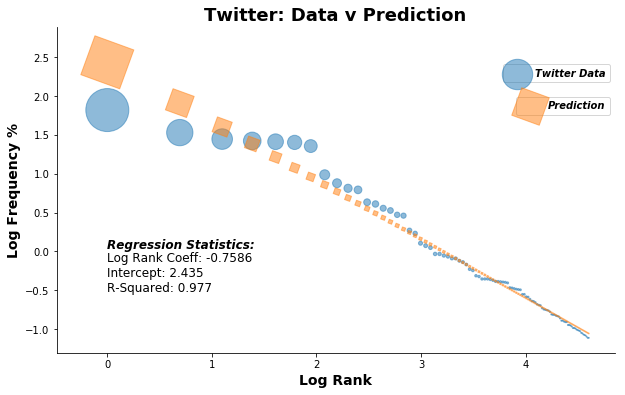

In [685]:
source_list = ['reddit','nyt','twitter']
name_list = ['Reddit','New York Times','Twitter']

for i in range(len(source_list)):
    plot_zipf(source_list[i],name_list[i],False)

In [263]:
shortlist = list()
for i in range(len(twitter)):
    if len(twitter['twitter_word'].iloc[i]) <= 3:
        shortlist.append(twitter.index[i])
len(shortlist)

51

In [681]:
twitter.loc[shortlist].head(20)

,twitter_word,twitter_freq,twitter_perc,twitter_perc_cum
0,IN,2501,6.168759,6.168759
1,JOB,1871,4.614853,10.783612
2,THE,1721,4.244876,15.028488
3,TO,1681,4.146215,19.174703
4,AT,1664,4.104284,23.278988
5,A,1649,4.067287,27.346274
7,FOR,1087,2.681104,33.907210
9,AND,913,2.251930,38.563994
10,YOU,895,2.207533,40.771527
11,OF,763,1.881952,42.653479


In [680]:
twitter.loc[shortlist].tail(20)

,twitter_word,twitter_freq,twitter_perc,twitter_perc_cum
56,NY,219,0.540167,82.218879
57,UP,214,0.527835,82.746713
59,WE,210,0.517969,83.790050
60,AM,205,0.505636,84.295686
62,BY,202,0.498236,85.294625
72,…,177,0.436574,89.877414
73,TX,176,0.434107,90.311521
74,°F,175,0.431640,90.743162
75,ARE,171,0.421774,91.164936
77,SO,166,0.409442,91.983820


In [679]:
test = twitter.drop(shortlist).head(20)
test.reset_index().head()

,index,twitter_word,twitter_freq,twitter_perc,twitter_perc_cum
0,6,HIRING,1573,3.879831,31.226106
1,8,THIS,975,2.404854,36.312064
2,12,JOBS,746,1.840022,44.493501
3,18,LATEST,511,1.260390,53.681277
4,19,WITH,450,1.109933,54.791209
